<a href="https://colab.research.google.com/github/Yeen000/Aiffel/blob/master/3_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경설정

In [ ]:
!pip install koreanize-matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import koreanize_matplotlib

plt.rc('font', family='NanumBarunGothic')

In [ ]:
!pip install koreanize-matplotlib

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import koreanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
# 추가된 테이블
u_pord = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/아이펠/아이펠 통계_프로젝트/프로젝트_공유드라이브/u_prod.csv") #가격정보생성테이블
orders_products_f = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/아이펠/아이펠 통계_프로젝트/프로젝트_공유드라이브/orders_products_f.csv") #최종 order_product_f 테이블
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/아이펠/아이펠 통계_프로젝트/프로젝트_공유드라이브/users.csv") #user 테이블
f_orders = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/아이펠/아이펠 통계_프로젝트/프로젝트_공유드라이브/f_orders.csv") #user 테이블

In [ ]:
f_orders.sort_values(by='user_id')

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart_order_cnt,reorder_cnt,total_price,max_price,total_reordered_price,is_reorder
0,2539329,1,prior,1,2,8,0.0,5,0,12.06,42.11,0.00,0
10,1187899,1,train,11,4,8,14.0,11,10,13.18,82.94,76.99,1
9,2550362,1,prior,10,4,8,30.0,9,6,12.44,60.32,40.73,1
7,3108588,1,prior,8,1,14,14.0,6,4,13.18,49.21,31.22,1
6,550135,1,prior,7,1,9,20.0,5,5,12.06,35.92,35.92,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346071,1542354,206209,prior,3,5,11,30.0,15,8,35.37,154.30,101.96,1
3346070,1889163,206209,prior,2,3,17,7.0,9,6,46.33,133.24,114.49,1
3346069,3154581,206209,prior,1,3,11,0.0,13,0,46.33,170.38,0.00,0
3346074,3186442,206209,prior,6,0,16,3.0,2,1,6.94,8.32,1.38,1


In [ ]:
# 유저별 총 구매금액
users.isnull().sum()

,0
user_id,0
total_reorder_count,0
avg_cart_order_cnt,0
avg_reorder_cnt,0
avg_reorder_price,0
avg_days_since_prior_order,0
recency,0
frequency,0
monetary,0


# LTV 관련 지표 및 LTV 테이블 생성

## 이탈 고객 확인

✅ 결론
- 가장 최근 주문(order_number가 max) 이후 경과한 일수(recency)를 활용하여 이탈고객 정의
- 이탈 고객은 평균 구매 주기의 2배 이상 주문하지 않은 고객으로 설정
- 이탈 고객 비율을 확인하여 문제의 심각성 파악
- 이탈 고객을 줄이기 위한 맞춤형 마케팅 전략 수립 가능 🚀

조건:\
✅ recency ≥ avg_days_since_prior_order * 2 → 이탈 고객 (is_churn = 1)\
✅ 그렇지 않으면 유지 고객 (is_churn = 0)

In [ ]:
# 총 매출 (Total Revenue)
total_revenue = f_orders["total_price"].sum()

# 총 활성 사용자 수 (Total Users)
total_users = f_orders["user_id"].nunique()

# ARPU 계산 : 총 매출액 / 활성유저수 :  고객 1인당 기업 매출에 기여한 정도
ARPU = total_revenue / total_users
print(f"ARPU (1인당 평균 구매 금액): {ARPU:.2f}")

ARPU (1인당 평균 구매 금액): 576.12


In [ ]:
# 고객별 가장 최근 주문(order_number가 max인 주문)의 days_since_prior_order 값 가져오기
user_recency = f_orders.loc[f_orders.groupby("user_id")["order_number"].idxmax(), ["user_id", "days_since_prior_order"]]
user_recency.columns = ["user_id", "recency"]

# 유저별 평균 구매 주기 계산
user_avg_purchase_interval = f_orders.groupby("user_id")["days_since_prior_order"].mean().reset_index()
user_avg_purchase_interval.columns = ["user_id", "avg_days_since_prior_order"]

In [ ]:
# 이탈 고객 판별: 최근 주문 후 경과 일수가 평균 구매 주기의 2배 이상이면 이탈 고객
churn_users = user_avg_purchase_interval.merge(user_recency, on="user_id")
churn_users["is_churn"] = (churn_users["recency"] >= churn_users["avg_days_since_prior_order"] * 2).astype(int)

In [ ]:
# 이탈 고객 목록 출력
churned_users_list = churn_users[churn_users["is_churn"] == 1]
print(f"이탈 고객 수: {churned_users_list.shape[0]}")

이탈 고객 수: 28603


In [ ]:
churned_users_list

,user_id,avg_days_since_prior_order,recency,is_churn
5,6,6.000000,12.0,1
16,17,7.804878,30.0,1
20,21,10.147059,28.0,1
21,22,12.666667,30.0,1
22,23,14.800000,30.0,1
...,...,...,...,...
206154,206155,4.800000,15.0,1
206193,206194,11.181818,30.0,1
206194,206195,7.600000,30.0,1
206203,206204,11.250000,25.0,1


In [ ]:
# 총 유저 수
total_users = f_orders["user_id"].nunique()

# 이탈 고객 수
churn_user_count = churned_users_list["user_id"].nunique()

# 이탈률 계산
churn_rate = churn_user_count / total_users
print(f"📌 이탈 고객 비율: {churn_rate:.2%}")

📌 이탈 고객 비율: 13.87%


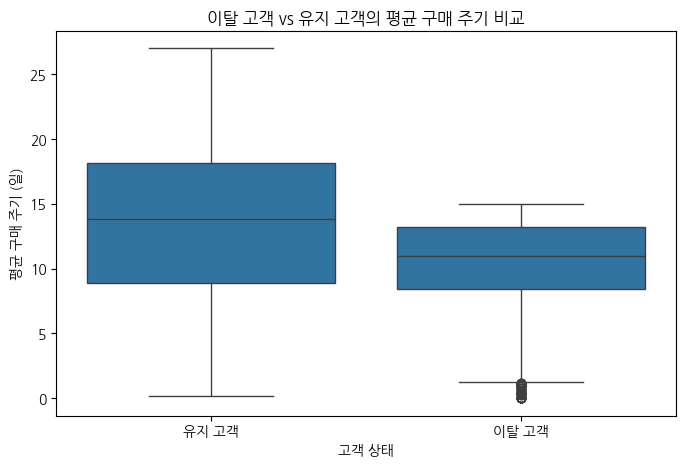

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=churn_users["is_churn"], y=churn_users["avg_days_since_prior_order"])
plt.xticks([0, 1], ["유지 고객", "이탈 고객"])
plt.xlabel("고객 상태")
plt.ylabel("평균 구매 주기 (일)")
plt.title("이탈 고객 vs 유지 고객의 평균 구매 주기 비교")
plt.show()

## LTV 주요 로직 및 구하기 및 users_ltv 테이블 생성

고객 생애 가치(Lifetime Value, LTV) : 한 고객이 기업과의 관계를 유지하는 동안 기업에 얼마나 많은 가치를 제공하는지를 나타내는 지표.

**LTV = 유저당 평균 구매 금액 × 구매 빈도 × 고객 유지 기간**

각 요소의 의미:

1. 유저당 평균 구매 금액: 고객이 한 번 구매할 때 지출하는 평균 금액을 나타내며, 이는 고객의 구매력과 기업 제품 또는 서비스의 가격대를 반영​

2. 구매 빈도: 고객이 얼마나 자주 구매하는지를 나타내며, 이는 고객의 충성도와 제품 또는 서비스의 필요성을 보여줌

3. 고객 유지 기간: 고객이 기업과 관계를 유지하는 평균 기간으로, 이는 고객 만족도와 기업의 고객 유지 전략의 효과성을 반영

📌 주요 로직
1. 유저별 평균 구매 금액 (Monetary)
monetary: 유저당 평균 구매 금액
2. 유저별 구매 빈도 (Frequency)
frequency: 유저가 총 몇 번 주문했는지
3. 이탈률 (Churn Rate)
평균 구매 주기의 2배 이상 주문하지 않은 고객을 이탈 고객으로 정의하여 이탈률 계산
4. 고객 유지 기간 (Customer Lifetime)
customer_lifetime = 1 / churn_rate
5. LTV 계산
LTV = monetary × frequency × customer_lifetime

is_churn == 1 : 이탈
is_churn == 0 : 유지

In [ ]:
# 1. 유저별 평균 구매 금액 (Monetary)
user_monetary = f_orders.groupby("user_id")["total_price"].mean().reset_index().round(2)
user_monetary.columns = ["user_id", "monetary"]

# 2. 유저별 구매 빈도 (Frequency)
user_frequency = f_orders.groupby("user_id")["order_number"].max().reset_index()
user_frequency.columns = ["user_id", "frequency"]

# 3. 고객별 가장 최근 주문 이후 경과 일수 (Recency)
user_recency = f_orders.loc[f_orders.groupby("user_id")["order_number"].idxmax(), ["user_id", "days_since_prior_order"]]
user_recency.columns = ["user_id", "recency"]

# 4. 유저별 평균 구매 주기 (Average Days Since Prior Order)
user_avg_purchase_interval = f_orders.groupby("user_id")["days_since_prior_order"].mean().reset_index()
user_avg_purchase_interval.columns = ["user_id", "avg_days_since_prior_order"]

# 5. 이탈 고객 판별 (Recency >= 평균 구매 주기의 2배)
churn_users = user_avg_purchase_interval.merge(user_recency, on="user_id")
churn_users["is_churn"] = (churn_users["recency"] >= churn_users["avg_days_since_prior_order"] * 2).astype(int)

# 6. 이탈률 (Churn Rate) 계산
churn_rate = churn_users["is_churn"].sum() / churn_users.shape[0]
customer_lifetime = 1 / churn_rate if churn_rate > 0 else 0  # 무한대 방지

# 7. 유저별 LTV 계산
users_ltv = user_monetary.merge(user_frequency, on="user_id").merge(churn_users[["user_id", "is_churn","recency"]], on="user_id")
users_ltv["LTV"] = users_ltv["monetary"] * users_ltv["frequency"] * customer_lifetime

In [ ]:
users_ltv

,user_id,monetary,frequency,is_churn,recency,LTV
0,1,16.64,11,0,14.0,1319.599181
1,2,40.80,15,0,30.0,4412.121386
2,3,39.95,12,0,15.0,3456.161752
3,4,75.11,5,0,0.0,2707.470893
4,5,31.91,5,0,6.0,1150.251580
...,...,...,...,...,...,...
206204,206205,60.33,4,0,10.0,1739.760021
206205,206206,23.97,67,1,11.0,11578.141870
206206,206207,35.01,16,0,18.0,4038.388751
206207,206208,35.42,49,0,7.0,12512.401364


In [ ]:
pd.set_option("display.float_format", "{:.2f}".format) #소수점 두자리까지

In [ ]:
users_ltv

,user_id,monetary,frequency,is_churn,recency,LTV
0,1,16.64,11,0,14.00,1319.60
1,2,40.80,15,0,30.00,4412.12
2,3,39.95,12,0,15.00,3456.16
3,4,75.11,5,0,0.00,2707.47
4,5,31.91,5,0,6.00,1150.25
...,...,...,...,...,...,...
206204,206205,60.33,4,0,10.00,1739.76
206205,206206,23.97,67,1,11.00,11578.14
206206,206207,35.01,16,0,18.00,4038.39
206207,206208,35.42,49,0,7.00,12512.40


# LTV_인사이트

In [ ]:
# users_ltv 파일 불러오기
users_ltv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/아이펠/아이펠 통계_프로젝트/프로젝트_공유드라이브/users_ltv.csv")
users_ltv

,user_id,monetary,frequency,is_churn,recency,LTV
0,1,16.64,11,0,14.00,1319.60
1,2,40.80,15,0,30.00,4412.12
2,3,39.95,12,0,15.00,3456.16
3,4,75.11,5,0,0.00,2707.47
4,5,31.91,5,0,6.00,1150.25
...,...,...,...,...,...,...
206204,206205,60.33,4,0,10.00,1739.76
206205,206206,23.97,67,1,11.00,11578.14
206206,206207,35.01,16,0,18.00,4038.39
206207,206208,35.42,49,0,7.00,12512.40


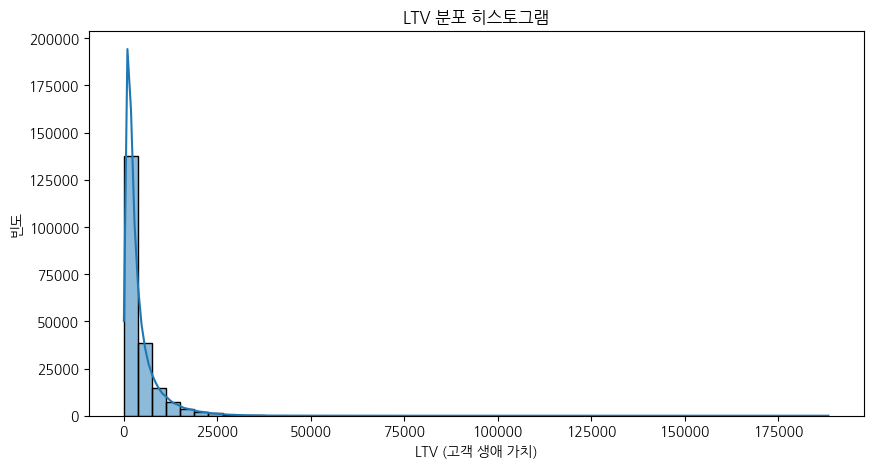

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(users_ltv["LTV"], bins=50, kde=True)
plt.xlabel("LTV (고객 생애 가치)")
plt.ylabel("빈도")
plt.title("LTV 분포 히스토그램")
plt.show()

✅ 주요 해석
1. 대부분의 고객(LTV가 낮은 고객)

- **LTV가 0~10,000 범위에 집중**되어 있음.
- **즉, 많은 고객이 낮은 구매 금액 & 낮은 구매 빈도를 보임**
- **한두 번 구매 후 이탈하는 고객일 가능성이 높음**
- 재구매율을 높이기 위한 전략 필요 (예: 할인 쿠폰, 프로모션 제공).

2. 소수의 고객(LTV가 높은 고객)

- **25,000 이상부터 극소수의 고객이 존재**
- **일부 고객은 100,000 이상의 매우 높은 LTV를 가짐**
- **이 고객들은 고빈도 구매자 또는 고액 구매자일 가능성이 큼
- VIP 고객군을 대상으로 리워드 프로그램, 맞춤형 혜택 제공 필요.

3. 꼬리가 긴 분포 (Long Tail Distribution)

- 우측 꼬리가 길게 늘어남 → 지수 분포(Exponential Distribution) 형태를 띔.
- 이런 데이터는 로그 변환(Log Transformation)이나 군집 분석(K-Means, DBSCAN) 활용 시 더 명확한 분석 가능.

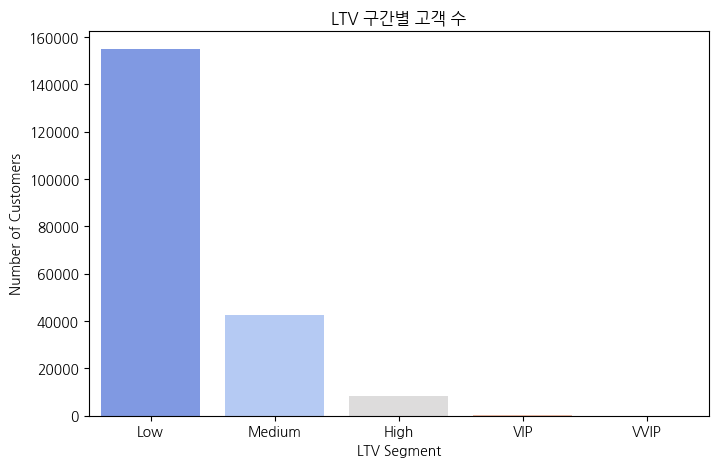

In [ ]:
# LTV 구간을 나눠서 고객 수 분석
bins = [0, 5000, 15000, 50000, 100000, users_ltv["LTV"].max()]
labels = ["Low", "Medium", "High", "VIP", "VVIP"]
users_ltv["LTV_Segment"] = pd.cut(users_ltv["LTV"], bins=bins, labels=labels, include_lowest=True)

# LTV 세그먼트별 고객 수 시각화
plt.figure(figsize=(8, 5))
sns.countplot(data=users_ltv, x="LTV_Segment", palette="coolwarm")
plt.xlabel("LTV Segment")
plt.ylabel("Number of Customers")
plt.title("LTV 구간별 고객 수")
plt.show()

In [ ]:
users_ltv["LTV_Segment"].value_counts().reset_index()

,LTV_Segment,count
0,Low,154943
1,Medium,42683
2,High,8387
3,VIP,170
4,VVIP,26


In [ ]:
users_ltv

,user_id,monetary,frequency,is_churn,recency,LTV,LTV_Segment
0,1,16.64,11,0,14.00,1319.60,Low
1,2,40.80,15,0,30.00,4412.12,Low
2,3,39.95,12,0,15.00,3456.16,Low
3,4,75.11,5,0,0.00,2707.47,Low
4,5,31.91,5,0,6.00,1150.25,Low
...,...,...,...,...,...,...,...
206204,206205,60.33,4,0,10.00,1739.76,Low
206205,206206,23.97,67,1,11.00,11578.14,Medium
206206,206207,35.01,16,0,18.00,4038.39,Low
206207,206208,35.42,49,0,7.00,12512.40,Medium


# 최종 피쳐 붙이고 최종 users_f 테이블 만들기

In [ ]:
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/아이펠/아이펠 통계_프로젝트/프로젝트_공유드라이브/users.csv") #user 테이블

## 재구매율

In [ ]:
# 피처 생성
## (1) 재구매비율 (reorder_ratio)
users['reorder_ratio'] = users['avg_reorder_cnt'] / users['avg_cart_order_cnt']

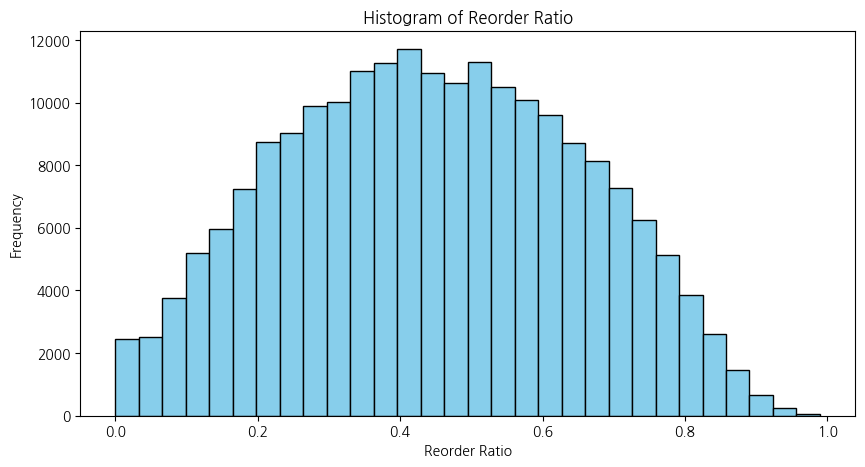

In [ ]:
## 히스토그램을 통해 재구매비율의 분포 살펴보기
import matplotlib.pyplot as plt

##히스토그램 그리기
plt.figure(figsize=(10, 5))
plt.hist(users['reorder_ratio'], bins=30, color='skyblue', edgecolor='black')

##그래프 레이블 설정
plt.xlabel('Reorder Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Reorder Ratio')

##그래프 출력
plt.show()

## 최고가/최저가

In [ ]:
## (2) 최고가/최저가 구매 제품 가격 (max_min_price)

 # 1. user_id별 최고가 제품과 최저가 제품의 가격 계산
price_diff_per_user = f_orders.groupby('user_id')['max_price'].agg(lambda x: x.max() - x.min()).reset_index()
price_diff_per_user.rename(columns={'max_price': 'max_min_price'}, inplace=True)

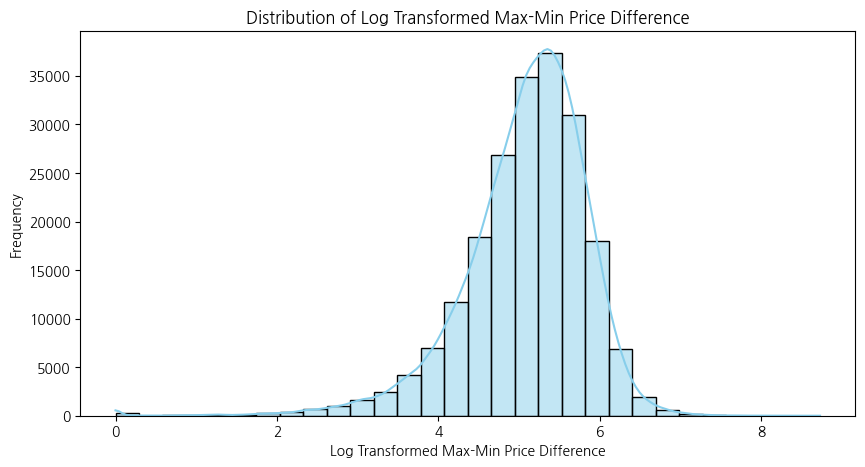

In [ ]:
# 2. users와 병합
users = users.merge(price_diff_per_user, on='user_id', how='left')

#분포가 치우쳐져 있음 => 로그 변환

# 3. 로그 변환
users['max_min_price_log'] = np.log1p(users['max_min_price'])

# 4. 로그 변환 후 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(users['max_min_price_log'], bins=30, kde=True, color='skyblue')
plt.xlabel('Log Transformed Max-Min Price Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Log Transformed Max-Min Price Difference')
plt.show()

In [ ]:
users #서희_피쳐까지concat

,user_id,total_reorder_count,avg_cart_order_cnt,avg_reorder_cnt,avg_reorder_price,avg_days_since_prior_order,recency,frequency,monetary,reorder_ratio,max_min_price,max_min_price_log
0,1,10,6.36,4.64,38.62,17.27,30.00,11,16.64,0.73,74.87,4.33
1,2,13,15.07,7.00,92.11,15.20,30.00,15,40.80,0.46,330.77,5.80
2,3,11,7.33,4.58,69.03,11.08,21.00,12,39.95,0.62,144.32,4.98
3,4,1,3.60,0.20,3.52,11.00,21.00,5,75.11,0.06,169.76,5.14
4,5,4,9.20,3.60,54.77,9.20,19.00,5,31.91,0.39,74.13,4.32
...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,12.75,3.50,59.25,12.50,30.00,4,60.33,0.27,218.15,5.39
206205,206206,63,4.25,2.01,22.41,3.72,15.00,67,23.97,0.47,183.49,5.22
206206,206207,15,13.94,8.19,79.39,13.44,30.00,16,35.01,0.59,203.38,5.32
206207,206208,48,13.82,9.78,124.76,7.29,20.00,49,35.42,0.71,356.53,5.88


## LTV 관련

In [ ]:
users_ltv

,user_id,monetary,frequency,is_churn,recency,LTV,LTV_Segment
0,1,16.64,11,0,14.00,1319.60,Low
1,2,40.80,15,0,30.00,4412.12,Low
2,3,39.95,12,0,15.00,3456.16,Low
3,4,75.11,5,0,0.00,2707.47,Low
4,5,31.91,5,0,6.00,1150.25,Low
...,...,...,...,...,...,...,...
206204,206205,60.33,4,0,10.00,1739.76,Low
206205,206206,23.97,67,1,11.00,11578.14,Medium
206206,206207,35.01,16,0,18.00,4038.39,Low
206207,206208,35.42,49,0,7.00,12512.40,Medium


In [ ]:
# users 테이블의 recency 값을 user_ltv 테이블의 recency 값으로 변경
users = users.drop(columns=["recency"])  # 기존 recency 삭제 후 새 값으로 대체
users = users.merge(users_ltv[["user_id", "recency"]], on="user_id", how="left")

In [ ]:
# user_ltv의 is_churn 및 LTV 컬럼을 users 테이블에 추가
users_f = users.merge(users_ltv[["user_id", "is_churn", "LTV"]], on="user_id", how="left")

In [ ]:
users_f

,user_id,total_reorder_count,avg_cart_order_cnt,avg_reorder_cnt,avg_reorder_price,avg_days_since_prior_order,frequency,monetary,reorder_ratio,max_min_price,max_min_price_log,recency,is_churn,LTV
0,1,10,6.36,4.64,38.62,17.27,11,16.64,0.73,74.87,4.33,14.00,0,1319.60
1,2,13,15.07,7.00,92.11,15.20,15,40.80,0.46,330.77,5.80,30.00,0,4412.12
2,3,11,7.33,4.58,69.03,11.08,12,39.95,0.62,144.32,4.98,15.00,0,3456.16
3,4,1,3.60,0.20,3.52,11.00,5,75.11,0.06,169.76,5.14,0.00,0,2707.47
4,5,4,9.20,3.60,54.77,9.20,5,31.91,0.39,74.13,4.32,6.00,0,1150.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,12.75,3.50,59.25,12.50,4,60.33,0.27,218.15,5.39,10.00,0,1739.76
206205,206206,63,4.25,2.01,22.41,3.72,67,23.97,0.47,183.49,5.22,11.00,1,11578.14
206206,206207,15,13.94,8.19,79.39,13.44,16,35.01,0.59,203.38,5.32,18.00,0,4038.39
206207,206208,48,13.82,9.78,124.76,7.29,49,35.42,0.71,356.53,5.88,7.00,0,12512.40


In [ ]:
users_f.isnull().sum()

,0
user_id,0
total_reorder_count,0
avg_cart_order_cnt,0
avg_reorder_cnt,0
avg_reorder_price,0
avg_days_since_prior_order,0
frequency,0
monetary,0
reorder_ratio,0
max_min_price,0


In [ ]:
users_f.describe()

,user_id,total_reorder_count,avg_cart_order_cnt,avg_reorder_cnt,avg_reorder_price,avg_days_since_prior_order,frequency,monetary,reorder_ratio,max_min_price,max_min_price_log,recency,is_churn,LTV
count,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00
mean,103105.00,14.30,9.98,4.58,57.92,13.20,16.23,35.30,0.44,202.48,5.08,16.70,0.14,4153.46
std,59527.56,16.42,5.84,3.81,51.09,5.46,16.66,20.84,0.21,138.38,0.77,10.59,0.35,5258.56
min,1.00,0.00,1.00,0.00,0.00,0.00,3.00,1.05,0.00,0.00,0.00,0.00,0.00,23.14
25%,51553.00,4.00,5.78,1.83,20.96,8.80,6.00,24.80,0.29,108.22,4.69,7.00,0.00,1240.58
50%,103105.00,8.00,9.00,3.57,44.50,13.04,10.00,32.63,0.44,176.82,5.18,15.00,0.00,2377.93
75%,154657.00,18.00,13.00,6.20,80.10,17.43,20.00,40.67,0.60,265.60,5.59,30.00,0.00,4974.88
max,206209.00,99.00,60.50,49.22,842.55,27.00,100.00,378.73,0.99,6165.80,8.73,30.00,1.00,188466.36


In [ ]:
users_f.to_csv("/content/drive/MyDrive/Colab Notebooks/아이펠/아이펠 통계_프로젝트/프로젝트_공유드라이브/users_f.csv", index=False)

# 피쳐 셀렉션

In [ ]:
users_f

,user_id,total_reorder_count,avg_cart_order_cnt,avg_reorder_cnt,avg_reorder_price,avg_days_since_prior_order,frequency,monetary,reorder_ratio,max_min_price,max_min_price_log,recency,is_churn,LTV
0,1,10,6.36,4.64,38.62,17.27,11,16.64,0.73,74.87,4.33,14.00,0,1319.60
1,2,13,15.07,7.00,92.11,15.20,15,40.80,0.46,330.77,5.80,30.00,0,4412.12
2,3,11,7.33,4.58,69.03,11.08,12,39.95,0.62,144.32,4.98,15.00,0,3456.16
3,4,1,3.60,0.20,3.52,11.00,5,75.11,0.06,169.76,5.14,0.00,0,2707.47
4,5,4,9.20,3.60,54.77,9.20,5,31.91,0.39,74.13,4.32,6.00,0,1150.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,12.75,3.50,59.25,12.50,4,60.33,0.27,218.15,5.39,10.00,0,1739.76
206205,206206,63,4.25,2.01,22.41,3.72,67,23.97,0.47,183.49,5.22,11.00,1,11578.14
206206,206207,15,13.94,8.19,79.39,13.44,16,35.01,0.59,203.38,5.32,18.00,0,4038.39
206207,206208,48,13.82,9.78,124.76,7.29,49,35.42,0.71,356.53,5.88,7.00,0,12512.40


In [ ]:
# # user_id 기준으로 총 구매수, 총 재구매수 합, 1인당 평균 구매가격, 1인당 평균 재구매가격 계산
# users = f_orders.groupby("user_id").agg(
#     total_reorder_count=("is_reorder", "sum"),  # 총 재구매 발생 횟수
#     avg_cart_order_cnt=("cart_order_cnt", "mean"),  # 평균 장바구니 크기(품목수)
#     avg_reorder_cnt=("reorder_cnt", "mean"),  # 평균 재구매 품목수
#     avg_reorder_price=("total_reordered_price", "mean"),  # 평균 재구매 가격
#     avg_days_since_prior_order=("days_since_prior_order", "mean"),# 평균 재구매 주기
#     #recency=("days_since_prior_order", "max"),  # 가장 최근 구매 이후 지난 일수
#     frequency=("order_number", "max"),  # 총 주문 횟수
#     monetary=("total_price", "mean")  # 1인당 평균 구매 가격 (거래 금액)
#     LTV # 고객 LTV ,

# ).reset_index()

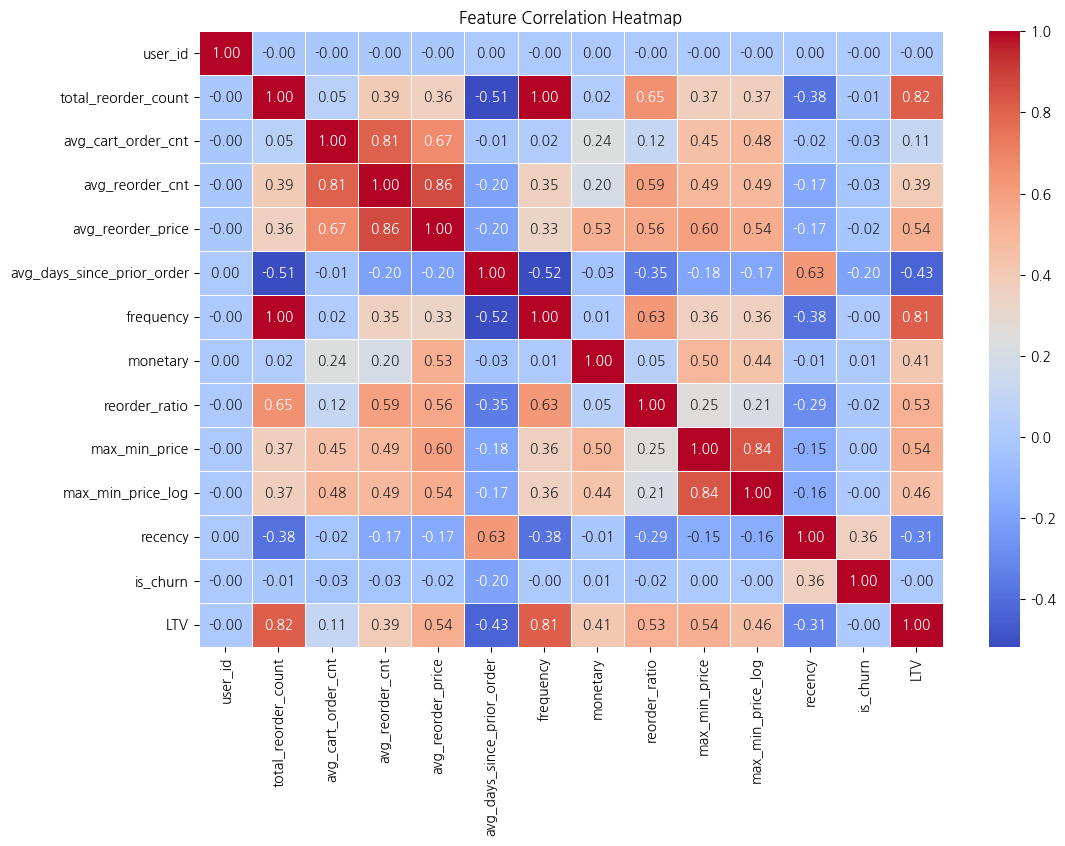

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 숫자형 변수만 선택
numeric_cols = users_f.select_dtypes(include=['float64', 'int64']).columns

# 상관 행렬 계산
corr_matrix = users_f[numeric_cols].corr()

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

🔍 해석

1.0 또는 -1.0에 가까울수록 강한 선형 관계가 있음.\
0.8 이상인 컬럼들은 다중공선성을 가질 가능성이 있음.\
상관관계가 낮은 변수는 Feature Selection에서 제외할 수도 있음.

0.8 이상의 상관관계를 가지는 변수 중 중복성이 있는 변수 제거.\
예를 들어 frequency와 total_order_count가 높은 상관성을 가진다면 하나만 유지.


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# ✅ 다중공선성 분석을 위한 수치형 변수 선택
numeric_cols = [
    "total_reorder_count", "avg_cart_order_cnt", "avg_reorder_cnt", "avg_reorder_price",
    "avg_days_since_prior_order", "recency", "frequency", "monetary",
    "reorder_ratio", "max_min_price", "max_min_price_log", "LTV"
]

# ✅ 데이터 스케일링 (VIF는 변수 크기에 영향을 받음)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(users_f[numeric_cols])

# ✅ VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(len(numeric_cols))]

# ✅ VIF 값 출력 (오름차순 정렬)
vif_data = vif_data.sort_values(by="VIF", ascending=True)
print(vif_data)

                       Feature    VIF
5                      recency   1.67
4   avg_days_since_prior_order   1.94
7                     monetary   3.16
10           max_min_price_log   3.82
9                max_min_price   4.08
8                reorder_ratio   4.85
11                         LTV   6.33
1           avg_cart_order_cnt   7.81
3            avg_reorder_price  10.18
2              avg_reorder_cnt  17.02
6                    frequency 152.51
0          total_reorder_count 158.99


💡 해석

VIF 값 10 이상: 강한 다중공선성 → 제거 고려\
VIF 값 5~10: 다중공선성 가능성 있음 → 변수 조정 필요\
VIF 값 5 이하: 다중공선성 문제 없음

In [ ]:
random_user_f = users_f

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Target이 없으므로 일단 군집화를 위한 더미 Target 생성 (랜덤)
random_user_f["dummy_target"] = (random_user_f["LTV"] > random_user_f["LTV"].median()).astype(int)

In [ ]:
print(users_f.columns)

Index(['user_id', 'total_reorder_count', 'avg_cart_order_cnt',
       'avg_reorder_cnt', 'avg_reorder_price', 'avg_days_since_prior_order',
       'frequency', 'monetary', 'reorder_ratio', 'max_min_price',
       'max_min_price_log', 'recency', 'is_churn', 'LTV', 'dummy_target'],
      dtype='object')


In [ ]:
print(random_user_f.columns)

Index(['user_id', 'total_reorder_count', 'avg_cart_order_cnt',
       'avg_reorder_cnt', 'avg_reorder_price', 'avg_days_since_prior_order',
       'frequency', 'monetary', 'reorder_ratio', 'max_min_price',
       'max_min_price_log', 'recency', 'is_churn', 'LTV', 'dummy_target'],
      dtype='object')


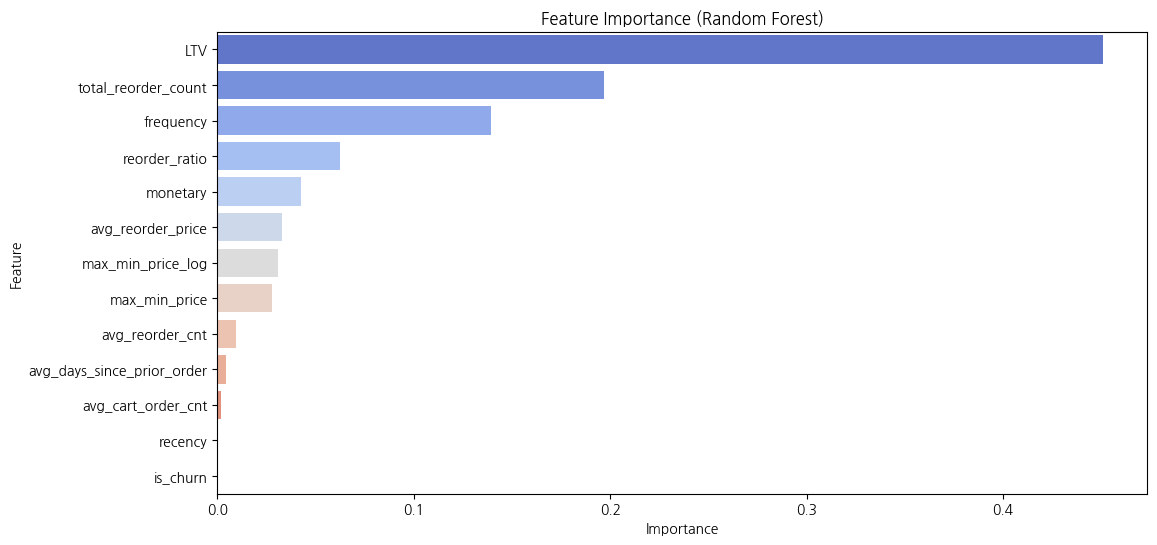

In [ ]:
# Feature & Target 분리
X = random_user_f.drop(columns=["user_id", "dummy_target"])
y = random_user_f["dummy_target"]

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Feature Importance 시각화
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="coolwarm")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [ ]:
users_f

,user_id,total_reorder_count,avg_cart_order_cnt,avg_reorder_cnt,avg_reorder_price,avg_days_since_prior_order,frequency,monetary,reorder_ratio,max_min_price,max_min_price_log,recency,is_churn,LTV,dummy_target
0,1,10,6.36,4.64,38.62,17.27,11,16.64,0.73,74.87,4.33,14.00,0,1319.60,0
1,2,13,15.07,7.00,92.11,15.20,15,40.80,0.46,330.77,5.80,30.00,0,4412.12,1
2,3,11,7.33,4.58,69.03,11.08,12,39.95,0.62,144.32,4.98,15.00,0,3456.16,1
3,4,1,3.60,0.20,3.52,11.00,5,75.11,0.06,169.76,5.14,0.00,0,2707.47,1
4,5,4,9.20,3.60,54.77,9.20,5,31.91,0.39,74.13,4.32,6.00,0,1150.25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,12.75,3.50,59.25,12.50,4,60.33,0.27,218.15,5.39,10.00,0,1739.76,0
206205,206206,63,4.25,2.01,22.41,3.72,67,23.97,0.47,183.49,5.22,11.00,1,11578.14,1
206206,206207,15,13.94,8.19,79.39,13.44,16,35.01,0.59,203.38,5.32,18.00,0,4038.39,1
206207,206208,48,13.82,9.78,124.76,7.29,49,35.42,0.71,356.53,5.88,7.00,0,12512.40,1


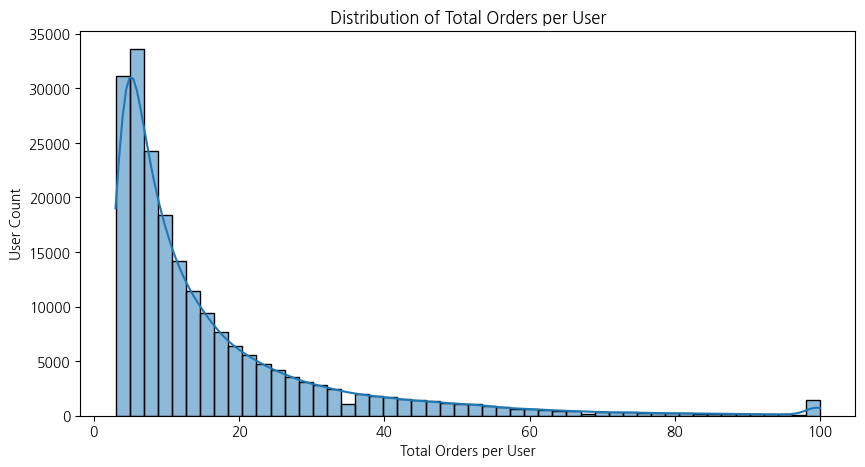

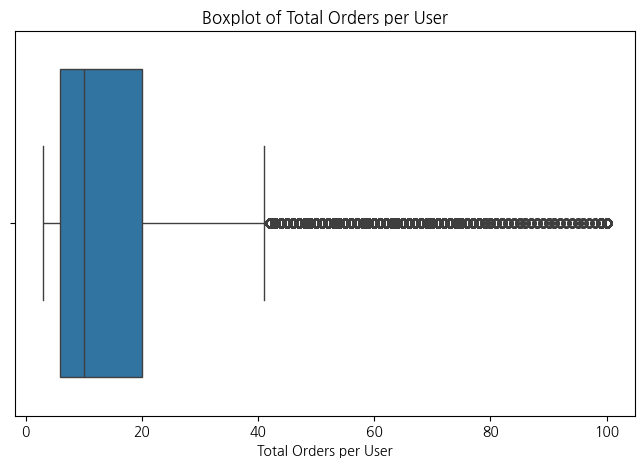

In [ ]:
# 유저당 총 주문 횟수 계산
user_order_stats = f_orders.groupby("user_id")["order_number"].max().reset_index()

# 유저당 평균 주문 횟수 분포 (히스토그램)
plt.figure(figsize=(10,5))
sns.histplot(user_order_stats["order_number"], bins=50, kde=True)
plt.xlabel("Total Orders per User")
plt.ylabel("User Count")
plt.title("Distribution of Total Orders per User")
plt.show()

# Boxplot으로 유저당 주문 횟수 이상치 확인
plt.figure(figsize=(8,5))
sns.boxplot(x=user_order_stats["order_number"])
plt.xlabel("Total Orders per User")
plt.title("Boxplot of Total Orders per User")
plt.show()

# 이상치값은 vip 많이 구매하는 유저라고 봐도 될듯 --> 구매수 들어가서 괜츈

In [ ]:
user_order_stats[user_order_stats['order_number']== 100].value_counts()

,,count
user_id,order_number,
210,100,1
142977,100,1
140395,100,1
140665,100,1
140672,100,1
...,...,...
66621,100,1
67433,100,1
67440,100,1


In [ ]:
# value_counts 결과
order_counts = user_order_stats['order_number'].value_counts()

# 총 빈도 계산
total_count = order_counts.sum()

# 누적 빈도 계산
cumulative_counts = order_counts.cumsum()

# 50% 기준
threshold = total_count * 0.5

# 50% 이상인 첫 번째 값을 찾기
peak_order_number = cumulative_counts[cumulative_counts > threshold].index[0]

peak_order_number

10

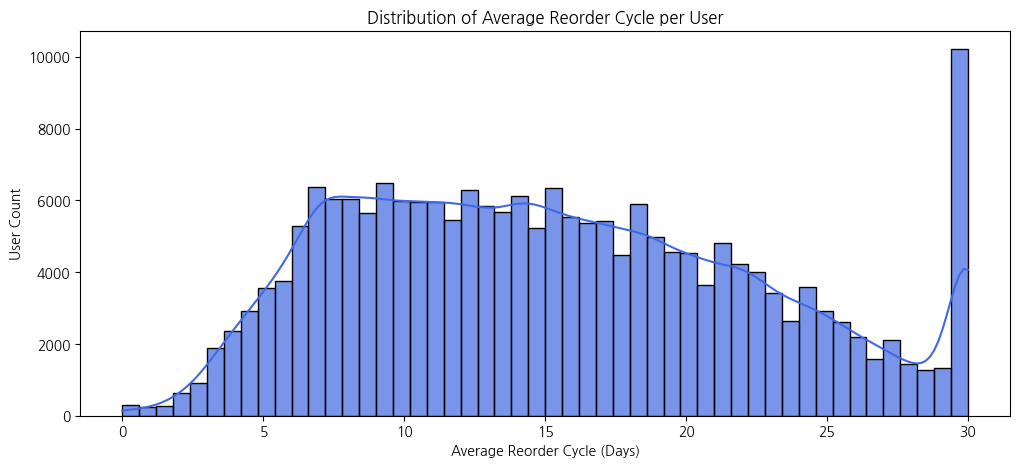

In [ ]:

# ✅ 유저별 평균 재구매 주기 계산
user_reorder_cycle = f_orders[f_orders["is_reorder"] == 1].groupby("user_id")["days_since_prior_order"].mean().reset_index()
user_reorder_cycle.columns = ["user_id", "avg_reorder_cycle"]

# ✅ 히스토그램 시각화
plt.figure(figsize=(12,5))
sns.histplot(user_reorder_cycle["avg_reorder_cycle"], bins=50, kde=True, color="royalblue", alpha=0.7)
plt.xlabel("Average Reorder Cycle (Days)")
plt.ylabel("User Count")
plt.title("Distribution of Average Reorder Cycle per User")
plt.show()

In [ ]:
users_f

,user_id,total_reorder_count,avg_cart_order_cnt,avg_reorder_cnt,avg_reorder_price,avg_days_since_prior_order,frequency,monetary,reorder_ratio,max_min_price,max_min_price_log,recency,is_churn,LTV,dummy_target
0,1,10,6.36,4.64,38.62,17.27,11,16.64,0.73,74.87,4.33,14.00,0,1319.60,0
1,2,13,15.07,7.00,92.11,15.20,15,40.80,0.46,330.77,5.80,30.00,0,4412.12,1
2,3,11,7.33,4.58,69.03,11.08,12,39.95,0.62,144.32,4.98,15.00,0,3456.16,1
3,4,1,3.60,0.20,3.52,11.00,5,75.11,0.06,169.76,5.14,0.00,0,2707.47,1
4,5,4,9.20,3.60,54.77,9.20,5,31.91,0.39,74.13,4.32,6.00,0,1150.25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,12.75,3.50,59.25,12.50,4,60.33,0.27,218.15,5.39,10.00,0,1739.76,0
206205,206206,63,4.25,2.01,22.41,3.72,67,23.97,0.47,183.49,5.22,11.00,1,11578.14,1
206206,206207,15,13.94,8.19,79.39,13.44,16,35.01,0.59,203.38,5.32,18.00,0,4038.39,1
206207,206208,48,13.82,9.78,124.76,7.29,49,35.42,0.71,356.53,5.88,7.00,0,12512.40,1


In [ ]:
user_reorder_cycle

,user_id,avg_reorder_cycle
0,1,19.00
1,2,15.23
2,3,12.09
3,4,21.00
4,5,11.50
...,...,...
204304,206205,16.67
204305,206206,3.90
204306,206207,14.33
204307,206208,7.44


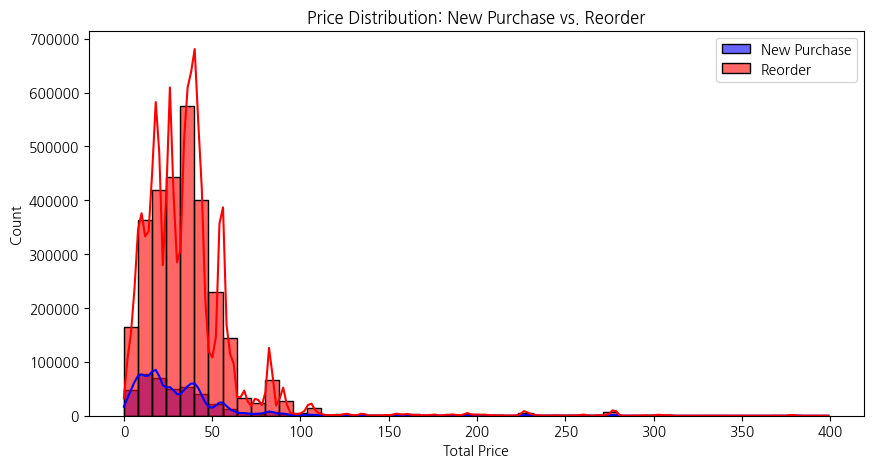

In [ ]:
plt.figure(figsize=(10, 5))

# 신규 구매
sns.histplot(f_orders[f_orders["is_reorder"] == 0]["total_price"], bins=50, kde=True, color="blue", label="New Purchase", alpha=0.6)

# 재구매
sns.histplot(f_orders[f_orders["is_reorder"] == 1]["total_price"], bins=50, kde=True, color="red", label="Reorder", alpha=0.6)

plt.xlabel("Total Price")
plt.ylabel("Count")
plt.title("Price Distribution: New Purchase vs. Reorder")
plt.legend()
plt.show()

재구매(빨강)가 신규 구매(파랑)보다 더 높은 빈도를 가짐
특히 저가 구간(0~50달러)에서 재구매 빈도가 압도적으로 많음
이는 고객들이 반복적으로 같은 제품을 재구매하는 경향을 보인다는 것을 의미
신규 구매는 상대적으로 분포가 넓고 낮음
신규 구매는 다양한 가격대에서 발생하지만, 빈도가 낮음
신규 고객들은 처음 구매 시 탐색을 많이 하며, 다양한 제품을 장바구니에 담을 가능성이 큼
고가 제품군(100달러 이상)에서는 차이가 크지 않음
고가 제품에서는 신규 구매와 재구매의 차이가 뚜렷하지 않음
즉, 높은 가격대의 제품은 고객들이 신중하게 구매하며, 반복적으로 구매하지 않을 가능성이 있음
비즈니스 인사이트 & 액션 아이디어

저가 제품에 대한 재구매 유도를 강화
특정 제품군에 대해 추가 할인을 제공하여 반복 구매를 촉진
신규 구매 고객을 재구매 고객으로 전환
첫 구매 후 일정 기간 내에 재구매를 유도하는 할인 쿠폰 제공
고가 제품의 충성 고객 전략
고가 제품을 여러 번 구매하는 고객을 VIP 고객으로 설정하여 추가 혜택 제공

In [ ]:
first_orders = f_orders[f_orders["order_number"] == 1][["user_id", "days_since_prior_order"]]
second_orders = f_orders[f_orders["order_number"] == 2][["user_id", "days_since_prior_order"]]

# 2. 첫 번째 구매와 두 번째 구매 데이터를 user_id 기준으로 병합
first_reorder_days = pd.merge(first_orders, second_orders, on="user_id", suffixes=("_first", "_second"))

# 3. 신규 구매 후 첫 번째 재구매까지 걸린 일 수 계산
first_reorder_days["days_until_reorder"] = first_reorder_days["days_since_prior_order_second"]

# 4. 평균 소요 기간 계산
average_days_until_reorder = first_reorder_days["days_until_reorder"].mean()

print(f"📌 신규 구매 후 첫 번째 재구매까지 평균 소요 기간: {average_days_until_reorder:.2f}일")

📌 신규 구매 후 첫 번째 재구매까지 평균 소요 기간: 15.34일


In [ ]:
f_orders[f_orders["order_number"] == 1]['days_since_prior_order'].value_counts()

,count
days_since_prior_order,
0.00,206209


In [ ]:
first_reorder_days #첫구매에서 두번째 구매까지 걸린 시간

,user_id,days_since_prior_order_first,days_since_prior_order_second,days_until_reorder
0,1,0.00,15.00,15.00
1,2,0.00,10.00,10.00
2,3,0.00,9.00,9.00
3,4,0.00,19.00,19.00
4,5,0.00,11.00,11.00
...,...,...,...,...
206204,206205,0.00,30.00,30.00
206205,206206,0.00,3.00,3.00
206206,206207,0.00,1.00,1.00
206207,206208,0.00,8.00,8.00


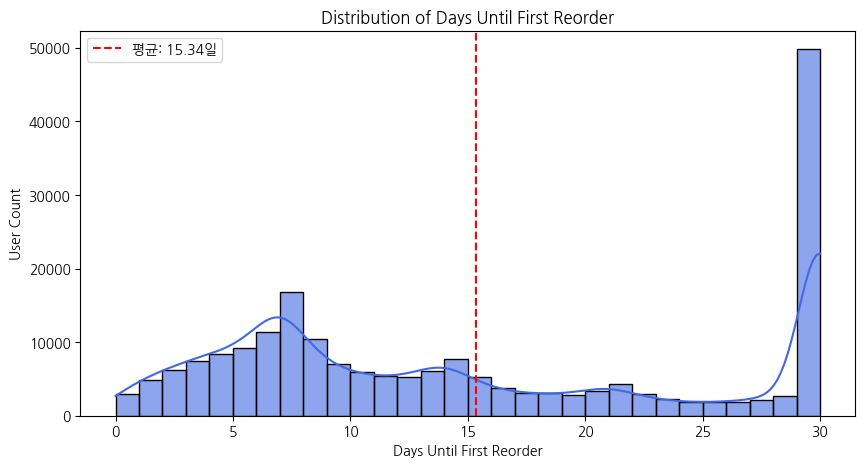

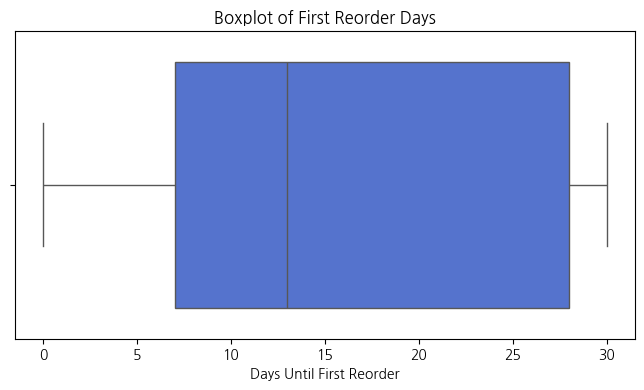

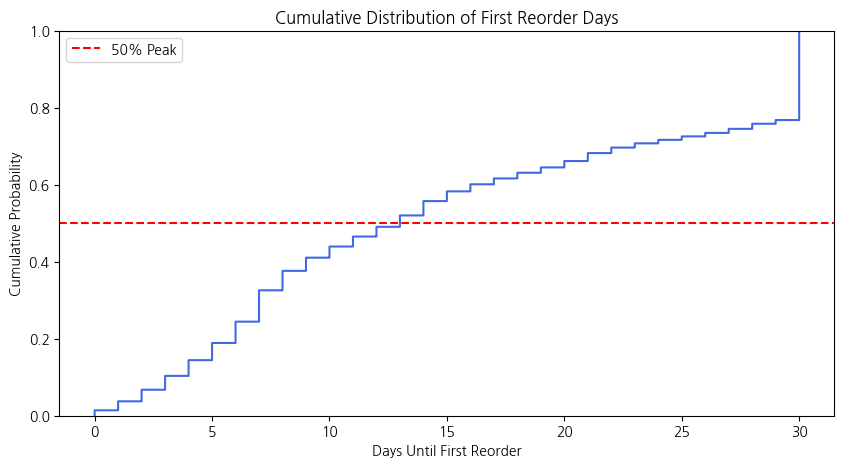

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 & KDE Plot (재구매까지 걸리는 일수 분포)
plt.figure(figsize=(10,5))
sns.histplot(first_reorder_days["days_until_reorder"], bins=30, kde=True, color="royalblue", alpha=0.6)
plt.axvline(first_reorder_days["days_until_reorder"].mean(), color='red', linestyle='--', label=f'평균: {first_reorder_days["days_until_reorder"].mean():.2f}일')
plt.xlabel("Days Until First Reorder")
plt.ylabel("User Count")
plt.title("Distribution of Days Until First Reorder")
plt.legend()
plt.show()

# 박스플롯 (Box Plot) - 재구매까지 걸리는 일수 분포 확인
plt.figure(figsize=(8,4))
sns.boxplot(x=first_reorder_days["days_until_reorder"], color="royalblue")
plt.xlabel("Days Until First Reorder")
plt.title("Boxplot of First Reorder Days")
plt.show()

# 누적 분포 함수 (CDF) - X일 이내 재구매 고객 비율
plt.figure(figsize=(10,5))
sns.ecdfplot(first_reorder_days["days_until_reorder"], color="royalblue")
plt.axhline(0.5, color="red", linestyle="--", label="50% Peak")
plt.xlabel("Days Until First Reorder")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of First Reorder Days")
plt.legend()
plt.show()

In [ ]:
first_get_users = users_f[users_f['avg_days_since_prior_order']==0].value_counts() #14명이 첫구매고객

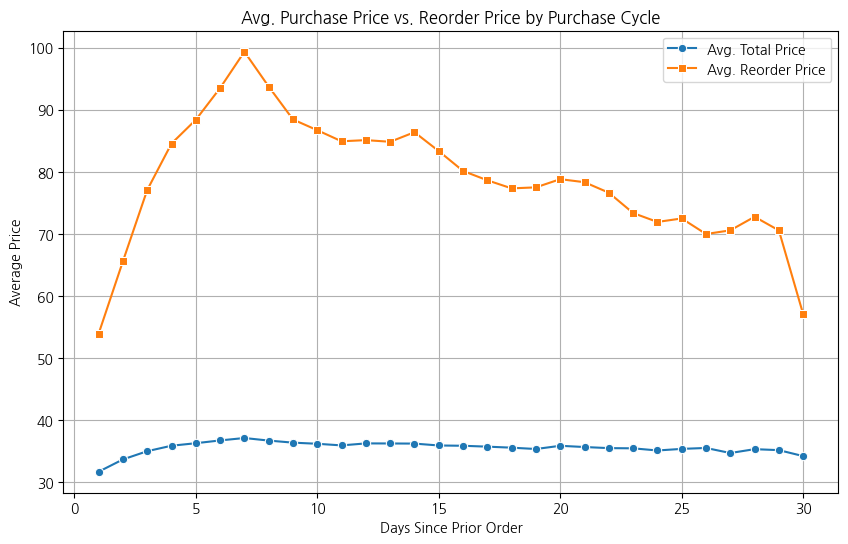

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 필터링: days_since_prior_order > 0
filtered_orders = f_orders[f_orders["days_since_prior_order"] > 0]

# 피벗 테이블 생성 (days_since_prior_order별 평균 total_price, total_reordered_price)
pivot_data = filtered_orders.pivot_table(index="days_since_prior_order",
                                         values=["total_price", "total_reordered_price"],
                                         aggfunc="mean")

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_data, x=pivot_data.index, y="total_price", label="Avg. Total Price", marker="o")
sns.lineplot(data=pivot_data, x=pivot_data.index, y="total_reordered_price", label="Avg. Reorder Price", marker="s")

# 그래프 스타일
plt.title("Avg. Purchase Price vs. Reorder Price by Purchase Cycle")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Average Price")
plt.legend()
plt.grid(True)  # 격자 추가
plt.show()


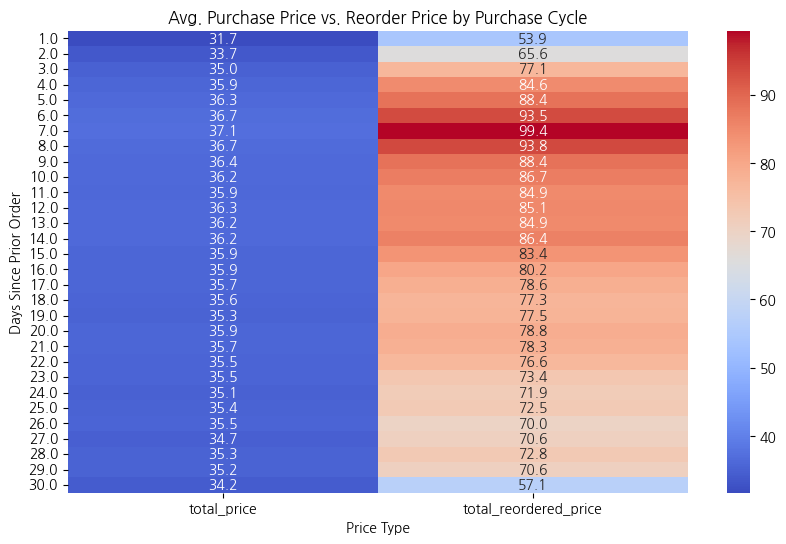

In [ ]:
filtered_orders = f_orders[f_orders["days_since_prior_order"] > 0]

plt.figure(figsize=(10, 6))
sns.heatmap(filtered_orders.pivot_table(index="days_since_prior_order",
                                       values=["total_price", "total_reordered_price"],
                                       aggfunc="mean"),
            cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Avg. Purchase Price vs. Reorder Price by Purchase Cycle")
plt.xlabel("Price Type")
plt.ylabel("Days Since Prior Order")
plt.show()


✅ 주요 패턴 및 인사이트
1. 재구매 주기가 짧을수록 재구매 가격이 높다 (7일 ~ 8일에서 최대)

재구매 주기 7일에서 8일에서 total_reordered_price(재구매 금액)가 **최고치(99.4)**에 도달
즉, 짧은 주기로 반복적으로 구매하는 고객이 더 많은 금액을 재구매
이는 정기적인 소비패턴을 가진 충성 고객을 의미할 가능성이 높음
따라서, 7~8일 단위 고객을 타겟으로 맞춤 마케팅(정기구독 혜택, 리워드 프로그램)이 효과적일 수 있음
2. 재구매 주기가 길어질수록 재구매 금액이 감소하는 경향

7~8일 이후부터 재구매 금액이 점차 감소
30일을 초과하면 재구매 금액이 큰 폭으로 줄어들며(57.1), 이탈 가능성이 높은 고객이 많아짐
30일 이상 재구매 없는 고객에게 쿠폰, 할인 프로모션 제공 필요
3. 첫 구매(0일)와 초기 재구매(1~2일)의 가격 차이가 크다

0일(첫 구매)에서 total_reordered_price 값이 16.3으로 매우 낮음 → 첫 구매에서 재구매 비중이 적음
그러나 1~3일 이후에는 재구매 금액이 급상승하며 구매 주기가 짧은 고객의 재구매 비중이 크다는 것을 시사
즉, 신규 고객을 유입 후 빠르게 첫 재구매를 유도하는 전략이 필요

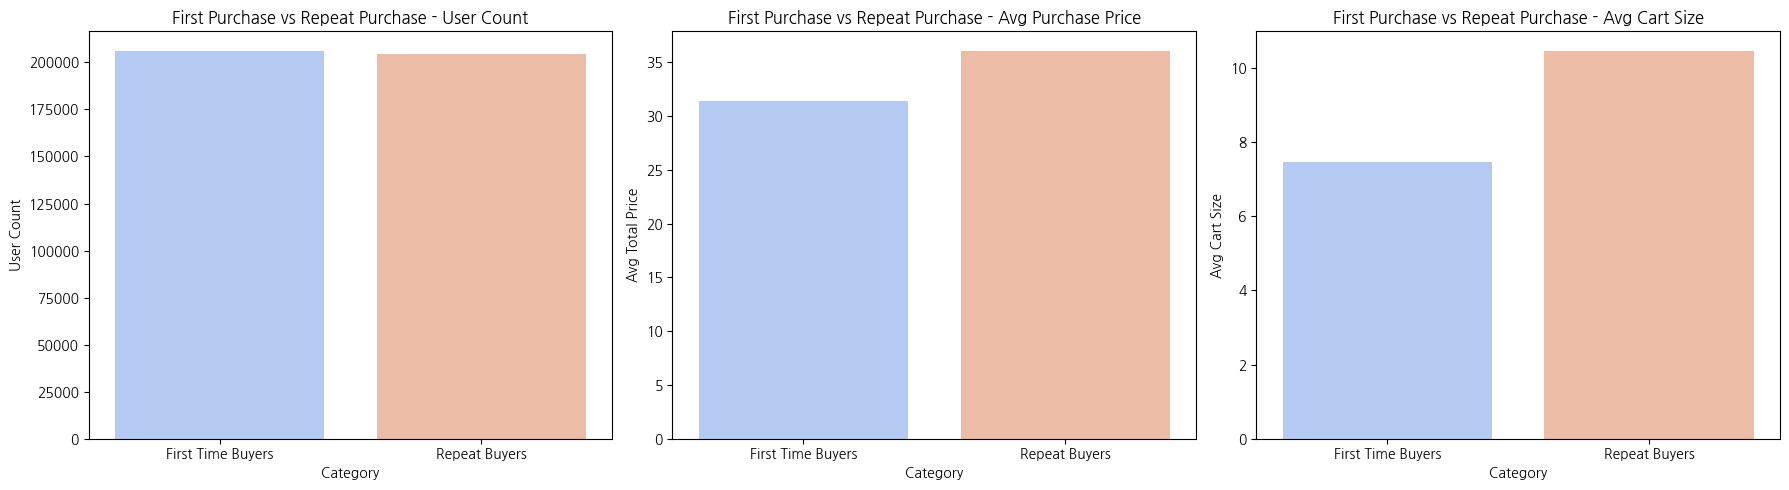

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 첫 구매 유저와 재구매 유저 분리
first_time_users = f_orders[f_orders["reorder_cnt"] == 0]
repeat_users = f_orders[f_orders["reorder_cnt"] > 0]

# 1. 빈도수 비교
user_counts = pd.DataFrame({
    "Category": ["First Time Buyers", "Repeat Buyers"],
    "User Count": [first_time_users["user_id"].nunique(), repeat_users["user_id"].nunique()]
})

# 2. 평균 구매 금액 비교
price_comparison = pd.DataFrame({
    "Category": ["First Time Buyers", "Repeat Buyers"],
    "Avg Total Price": [first_time_users["total_price"].mean(), repeat_users["total_price"].mean()]
})

# 3. 평균 장바구니 크기 비교
cart_size_comparison = pd.DataFrame({
    "Category": ["First Time Buyers", "Repeat Buyers"],
    "Avg Cart Size": [first_time_users["cart_order_cnt"].mean(), repeat_users["cart_order_cnt"].mean()]
})

# 4. 주요 변수별 평균 비교
feature_comparison = f_orders.groupby("is_reorder").agg({
    "total_price": "mean",
    "cart_order_cnt": "mean",
    "order_number": "mean",
    "days_since_prior_order": "mean",
}).rename(index={0: "First Time Buyers", 1: "Repeat Buyers"})

# 시각화 - 첫 구매 vs 재구매 고객 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 빈도수 비교
sns.barplot(data=user_counts, x="Category", y="User Count", palette="coolwarm", ax=axes[0])
axes[0].set_title("First Purchase vs Repeat Purchase - User Count")

# 2. 평균 구매 금액 비교
sns.barplot(data=price_comparison, x="Category", y="Avg Total Price", palette="coolwarm", ax=axes[1])
axes[1].set_title("First Purchase vs Repeat Purchase - Avg Purchase Price")

# 3. 평균 장바구니 크기 비교
sns.barplot(data=cart_size_comparison, x="Category", y="Avg Cart Size", palette="coolwarm", ax=axes[2])
axes[2].set_title("First Purchase vs Repeat Purchase - Avg Cart Size")

plt.tight_layout()
plt.show()


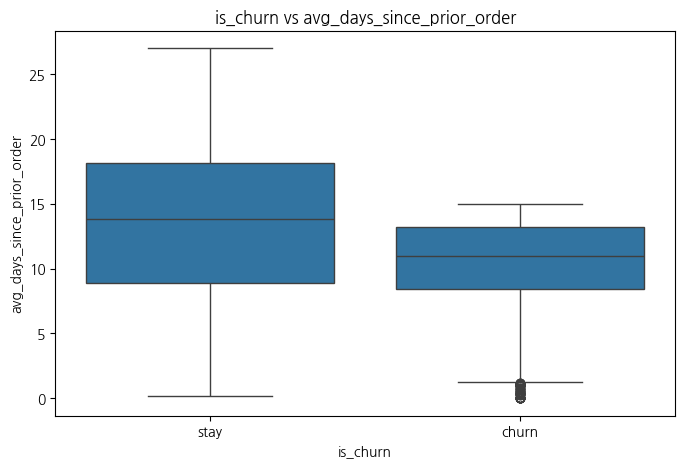

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=users_f["is_churn"], y=users_f["avg_days_since_prior_order"])
plt.xticks([0, 1], ["stay","churn"])
plt.xlabel("is_churn")
plt.ylabel("avg_days_since_prior_order")
plt.title("is_churn vs avg_days_since_prior_order")
plt.show()

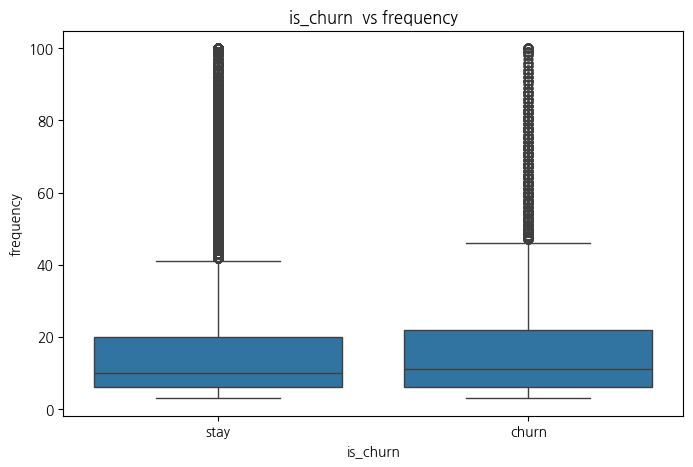

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=users_f["is_churn"], y=users_f["frequency"])
plt.xticks([0, 1], ["stay","churn"])
plt.xlabel("is_churn")
plt.ylabel("frequency")
plt.title("is_churn  vs frequency")
plt.show()

In [ ]:
# is_churn == 1 : 이탈, is_churn == 0 : 유지
users_f['is_churn'].value_counts()

,count
is_churn,
0,177606
1,28603


In [ ]:
# is_churn 별 주요 지표의 평균 계산
churn_summary = users_f.groupby("is_churn").agg(
    avg_days_since_prior_order=("avg_days_since_prior_order", "mean"),  # 평균 구매 주기
    avg_reorder_price=("avg_reorder_price", "mean"),  # 평균 재구매 금액
    monetary=("monetary", "mean"),  # 평균 구매 금액
    avg_cart_order_cnt=("avg_cart_order_cnt", "mean"),# 평균 장바구니 크기
    frequecy = ("frequency", 'mean'), #평균 구매 빈도
    LTV=("LTV", "mean"),  # 평균 LTV
    reorder_ratio = ('reorder_ratio','mean') #재구매율
).reset_index()

churn_summary

,is_churn,avg_days_since_prior_order,avg_reorder_price,monetary,avg_cart_order_cnt,frequecy,LTV,reorder_ratio
0,0,13.63,58.38,35.24,10.05,16.24,4154.20,0.45
1,1,10.54,55.04,35.67,9.58,16.16,4148.84,0.44


In [ ]:
users_f.head()